# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
import zipfile
from tensorflow.keras.utils import get_file
style.use('default')

In [2]:
plt.rcParams['backend'] = 'SVG'

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [3]:
fZipName = 'HIST_PAINEL_COVIDBR_03nov2020'
zf = zipfile.ZipFile('../data/' + fZipName + '.zip') 
df = pd.read_csv(zf.open( fZipName + '.csv'), sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248286 entries, 0 to 1248285
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   regiao                  1248286 non-null  object 
 1   estado                  1248033 non-null  object 
 2   municipio               1236540 non-null  object 
 3   coduf                   1248286 non-null  int64  
 4   codmun                  1241202 non-null  float64
 5   codRegiaoSaude          1236540 non-null  float64
 6   nomeRegiaoSaude         1236540 non-null  object 
 7   data                    1248286 non-null  object 
 8   semanaEpi               1248286 non-null  int64  
 9   populacaoTCU2019        1243624 non-null  float64
 10  casosAcumulado          1248286 non-null  int64  
 11  casosNovos              1248286 non-null  int64  
 12  obitosAcumulado         1248286 non-null  int64  
 13  obitosNovos             1248286 non-null  int64  
 14  Re

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['data'] = pd.to_datetime(df['data'],format="%Y-%m-%d")
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'DF'
Muni = 'Brasília'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_filter_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = preproc_filter_df(df, uf, Muni)

In [8]:

def casos_acumulados(df_muni, muni, pathfigs = './figs/'):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_log10_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Novos\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    print('Casos Totais\n', df_muni['casosAcumulado'].max())
    

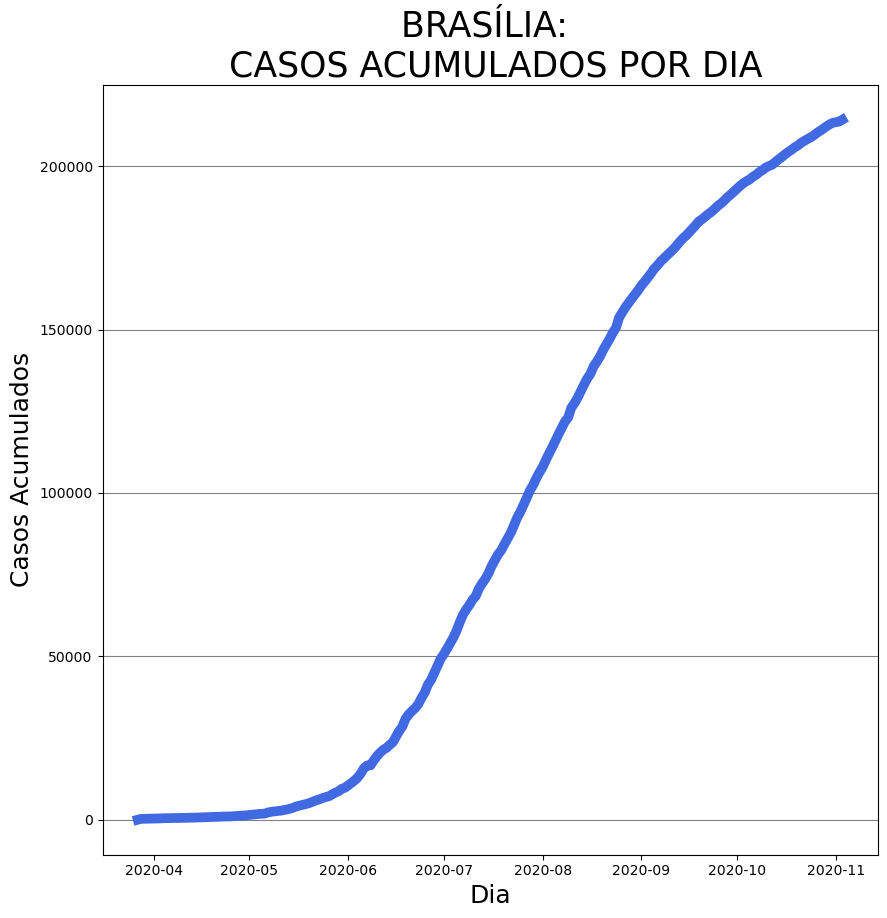

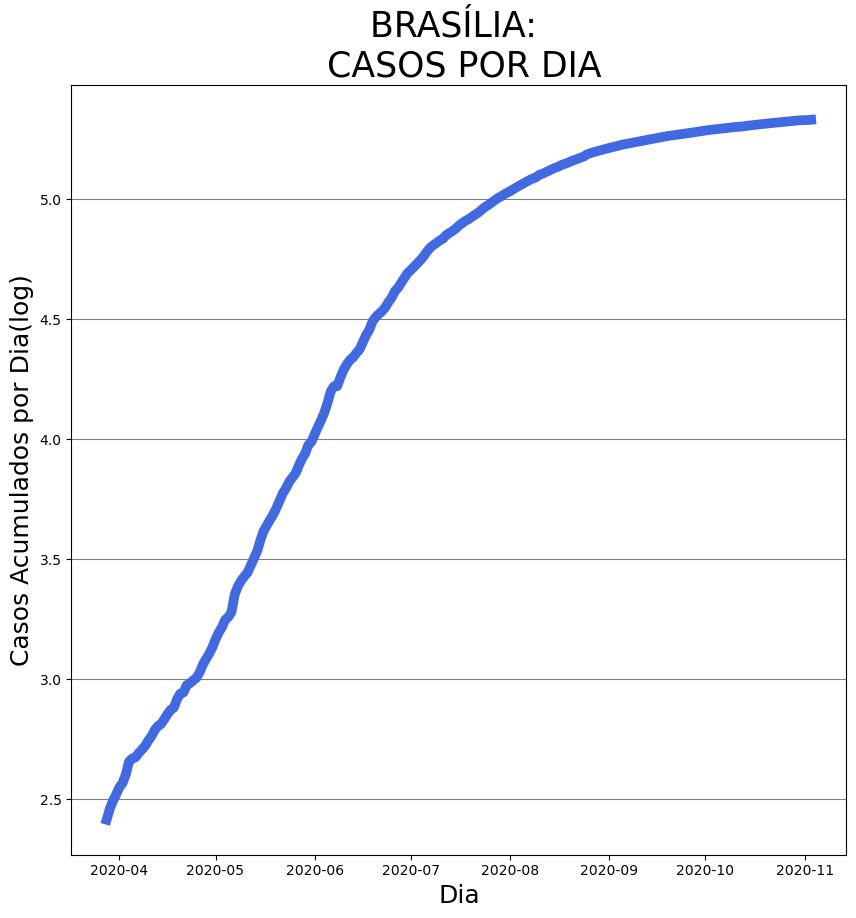

dia zero 2020-03-27 00:00:00
Casos Novos
          casosNovos       data
1248272         815 2020-10-21
1248273         590 2020-10-22
1248274         565 2020-10-23
1248275         526 2020-10-24
1248276         608 2020-10-25
1248277         776 2020-10-26
1248278         629 2020-10-27
1248279         668 2020-10-28
1248280         698 2020-10-29
1248281         622 2020-10-30
1248282         483 2020-10-31
1248283         211 2020-11-01
1248284         180 2020-11-02
1248285         566 2020-11-03
Casos Totais
 214202


In [9]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [10]:
def casos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    print('Casos Totais\n', df1['casosAcumulado'].max())

    fig = plt.figure(1, figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='casosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    
    plt.title('{}: \n Casos por Semana Epidemiológica por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=20)
    plt.ylabel('Número de Casos', fontsize=20)
    plt.grid(axis='y', color='grey')
    plt.rcParams['legend.title_fontsize'] = 18

    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)

Casos Totais
 214202


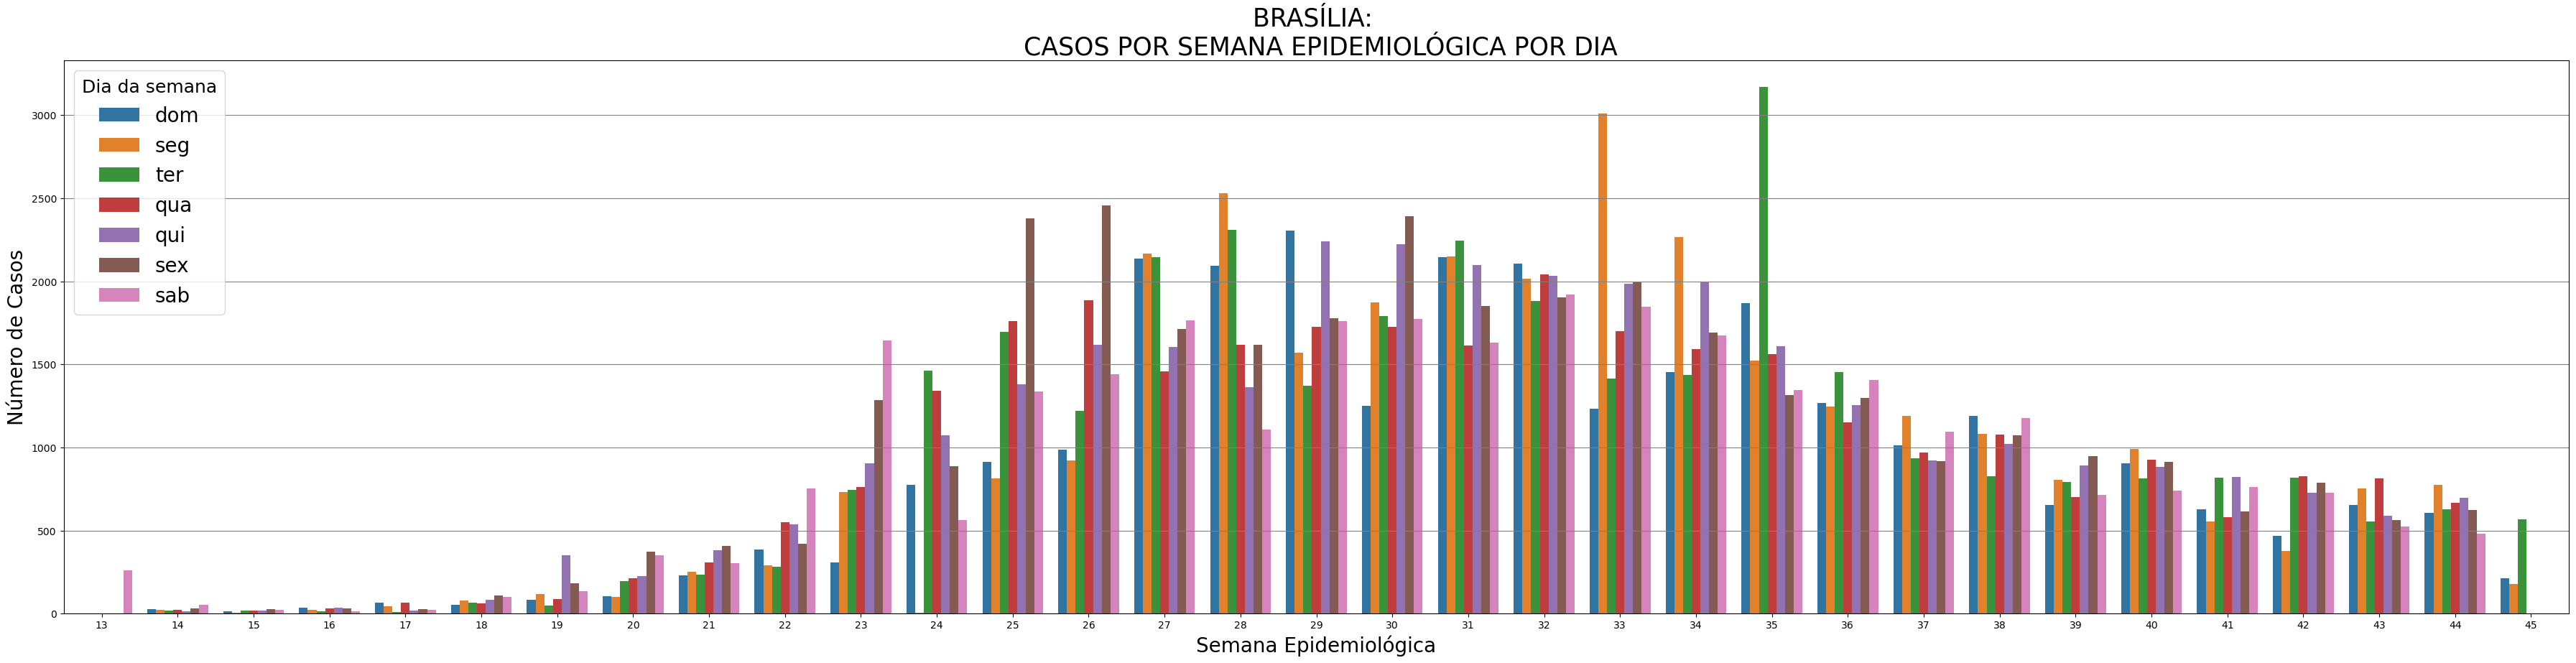

In [11]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 5 dias centralizada)

In [12]:
def casos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(7, center=False)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( pathfigs + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

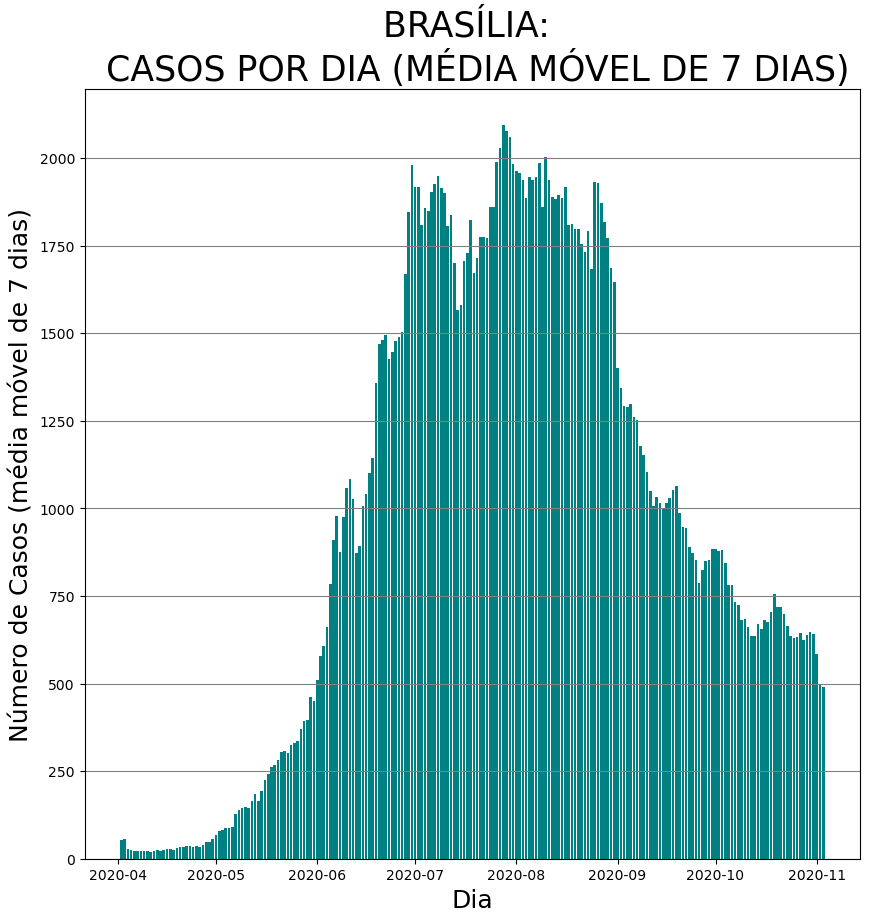

Média móvel por dia
          media_movel_casos       data
1248064                NaN 2020-03-27
1248065                NaN 2020-03-28
1248066                NaN 2020-03-29
1248067                NaN 2020-03-30
1248068                NaN 2020-03-31
1248069                NaN 2020-04-01
1248070          52.857143 2020-04-02
1248071          57.428571 2020-04-03
1248072          27.714286 2020-04-04
1248073          25.571429 2020-04-05
1248074          23.000000 2020-04-06
1248075          22.857143 2020-04-07
1248076          22.000000 2020-04-08
1248077          22.428571 2020-04-09
         media_movel_casos       data
1248272         717.428571 2020-10-21
1248273         697.714286 2020-10-22
1248274         665.571429 2020-10-23
1248275         636.714286 2020-10-24
1248276         630.285714 2020-10-25
1248277         633.714286 2020-10-26
1248278         644.142857 2020-10-27
1248279         623.142857 2020-10-28
1248280         638.571429 2020-10-29
1248281         646.714286 20

In [13]:
casos_dia_media_movel(df_cidade, Muni)

In [14]:
def obitos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))
    print('Óbitos Totais\n', df1['obitosAcumulado'].max())

    fig =  plt.figure(1,figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='obitosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    plt.title('{}: \n Óbitos por Semana Epidemiológica por dia da semana'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
    


Óbitos por dia
          obitosNovos       data
1248272           12 2020-10-21
1248273           13 2020-10-22
1248274           13 2020-10-23
1248275           10 2020-10-24
1248276           10 2020-10-25
1248277            8 2020-10-26
1248278           12 2020-10-27
1248279            8 2020-10-28
1248280            9 2020-10-29
1248281            6 2020-10-30
1248282            7 2020-10-31
1248283            5 2020-11-01
1248284            7 2020-11-02
1248285           12 2020-11-03
Óbitos Totais
 3707


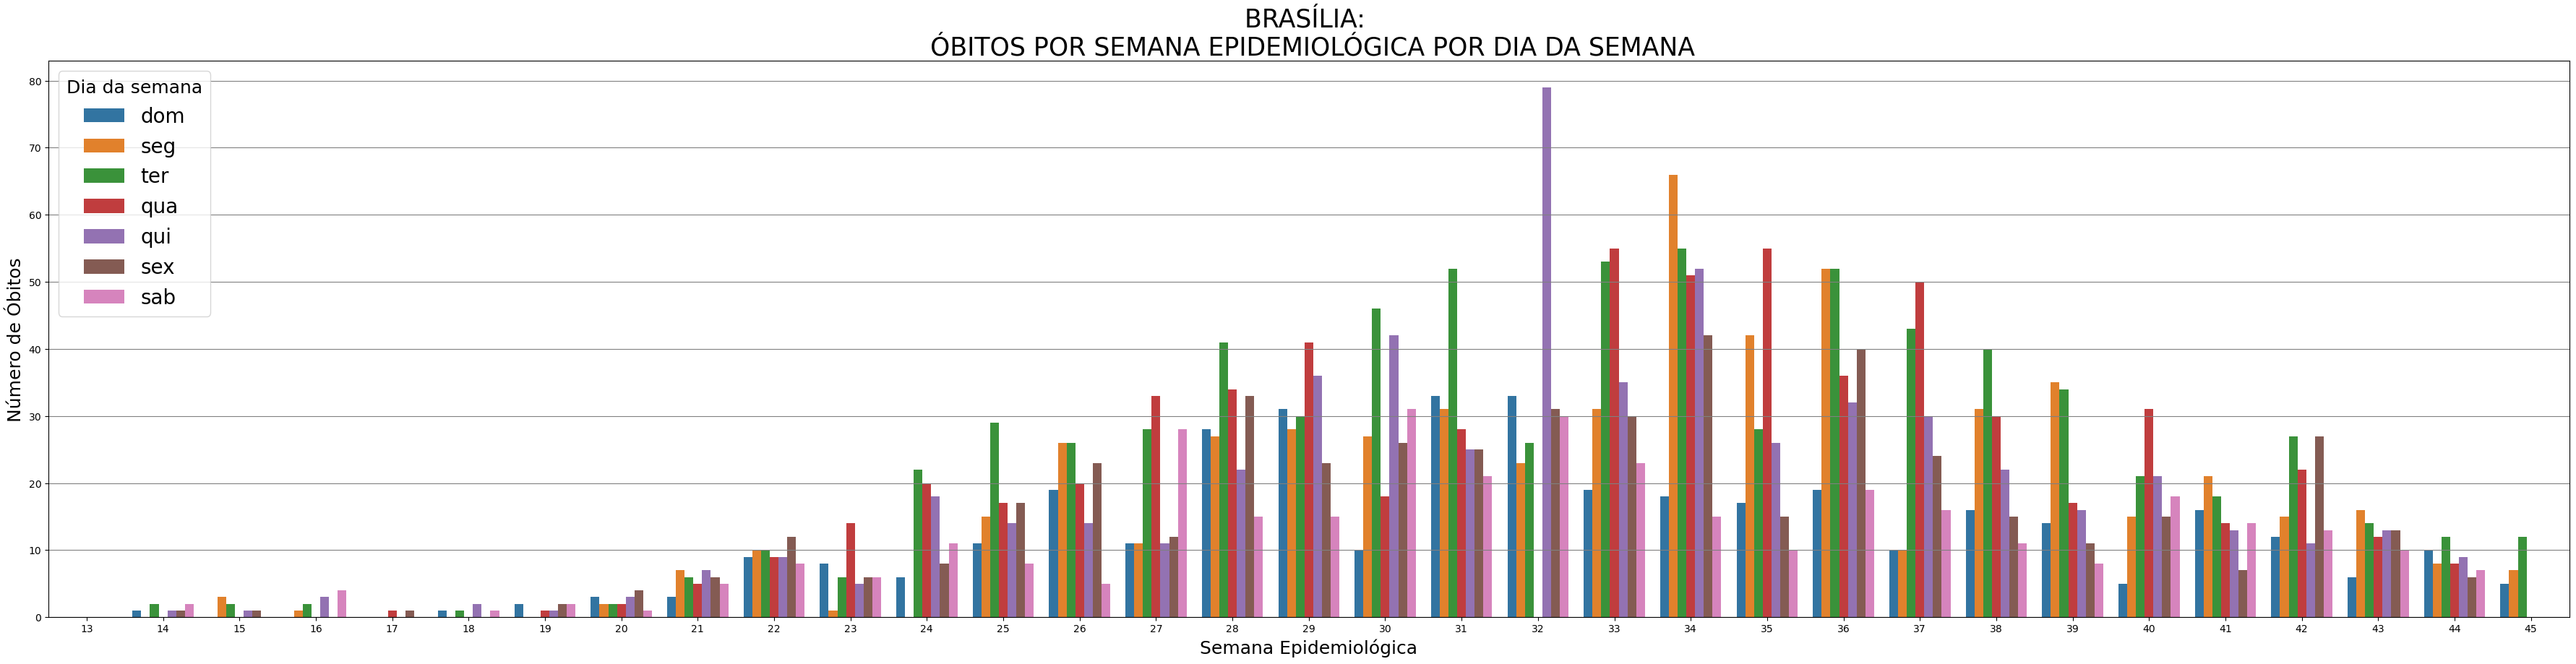

In [15]:
obitos_dia_local(df_cidade, Muni)

### Obitos por dia (média movel de 5 dias centralizada)

In [16]:
def obitos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(7, center=False)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( pathfigs + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

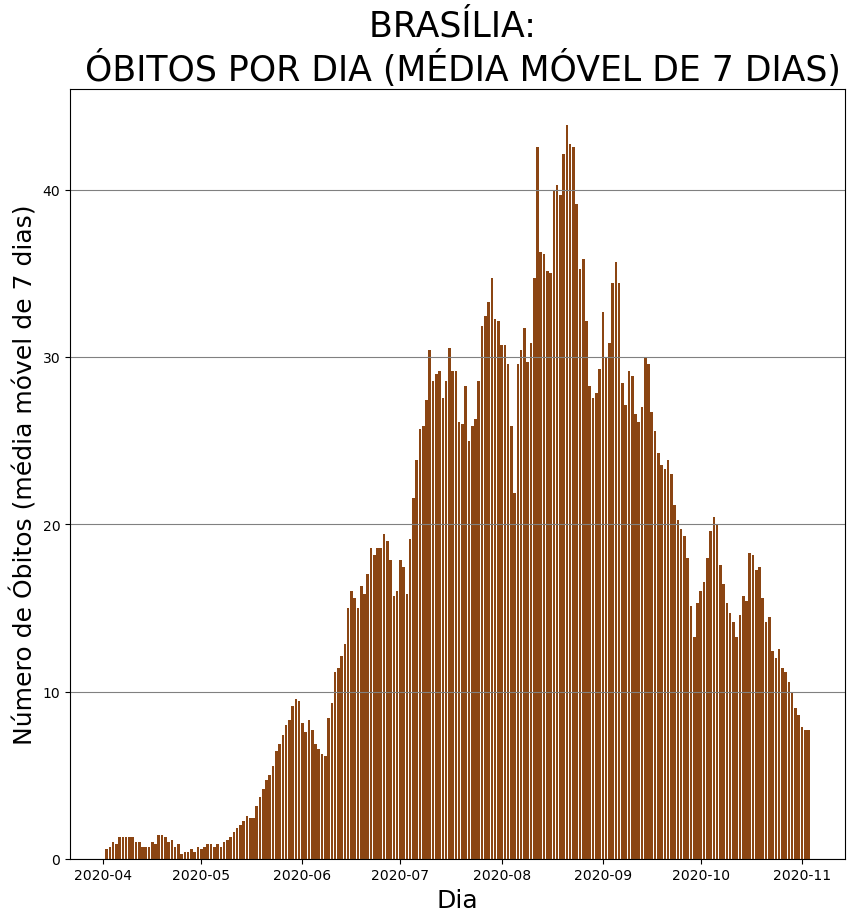

Média móvel por dia
          media_movel_obitos       data
1248064                 NaN 2020-03-27
1248065                 NaN 2020-03-28
1248066                 NaN 2020-03-29
1248067                 NaN 2020-03-30
1248068                 NaN 2020-03-31
1248069                 NaN 2020-04-01
1248070            0.571429 2020-04-02
1248071            0.714286 2020-04-03
1248072            1.000000 2020-04-04
1248073            0.857143 2020-04-05
1248074            1.285714 2020-04-06
1248075            1.285714 2020-04-07
1248076            1.285714 2020-04-08
1248077            1.285714 2020-04-09
         media_movel_obitos       data
1248272           14.142857 2020-10-21
1248273           14.428571 2020-10-22
1248274           12.428571 2020-10-23
1248275           12.000000 2020-10-24
1248276           12.571429 2020-10-25
1248277           11.428571 2020-10-26
1248278           11.142857 2020-10-27
1248279           10.571429 2020-10-28
1248280           10.000000 2020-10-29
1248

In [17]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [18]:
def casos_semana_local(df, local, pathfigs = './figs/'):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( pathfigs + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

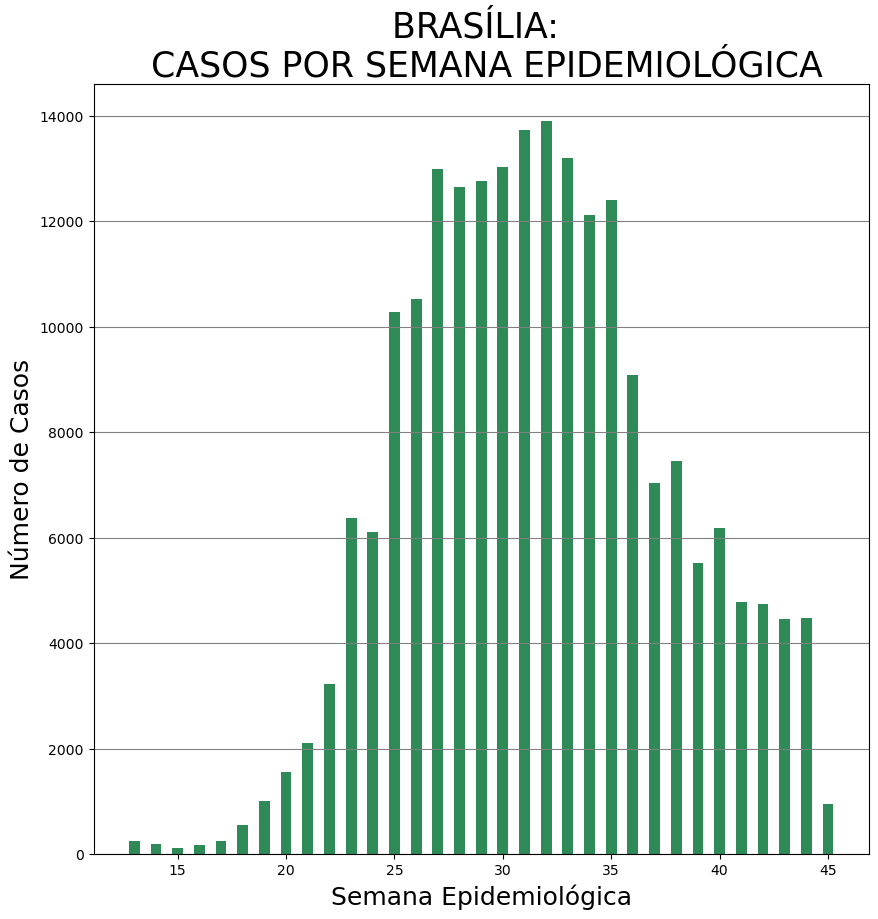

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13         260
1          14         194
2          15         125
3          16         183
4          17         251
5          18         553
6          19        1010
7          20        1564
8          21        2111
9          22        3223
10         23        6376
11         24        6109
12         25       10279
13         26       10528
14         27       12994
15         28       12646
16         29       12757
17         30       13024
18         31       13735
19         32       13902
20         33       13190
21         34       12113
22         35       12399
23         36        9079
24         37        7041
25         38        7450
26         39        5512
27         40        6175
28         41        4786
29         42        4735
30         43        4457
31         44        4484
32         45         957


In [19]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [20]:
def obitos_semana_local(df, local, pathfigs = './figs/'):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( pathfigs + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')


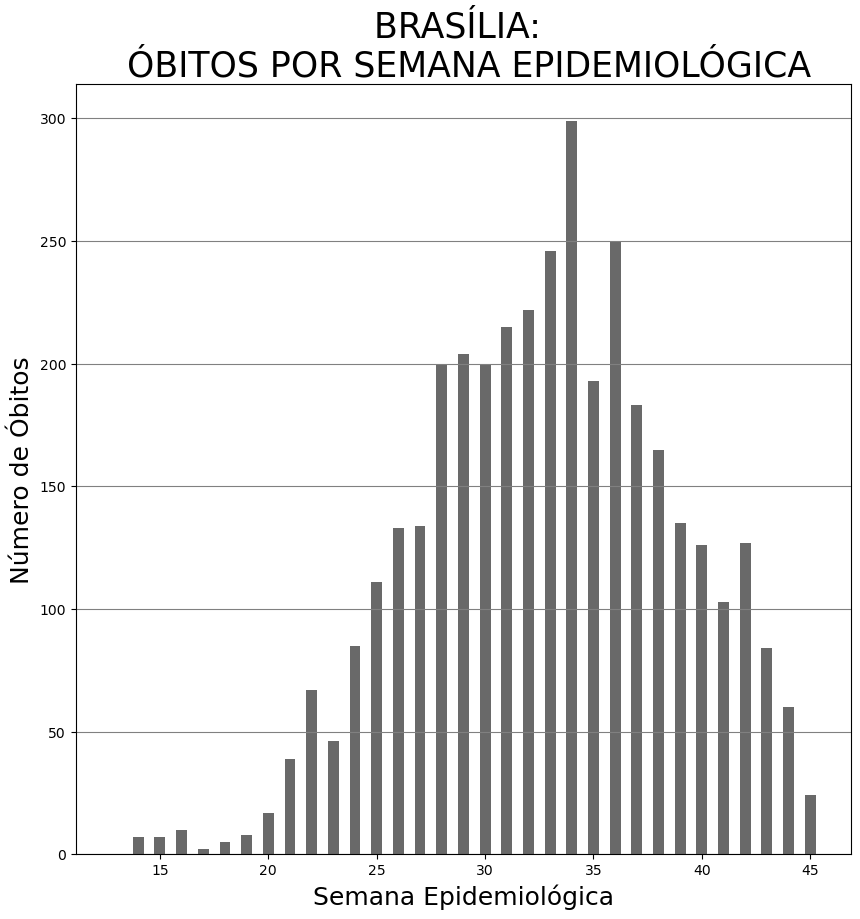

In [21]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [22]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\gitRepos\graficos_covid\acompanhamento_df


'd:\\gitRepos\\graficos_covid\\acompanhamento_df\\geojsonDL\\DF.json'

### Carregando arquivo GeoJson do estado

In [23]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [24]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid-19 -- {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

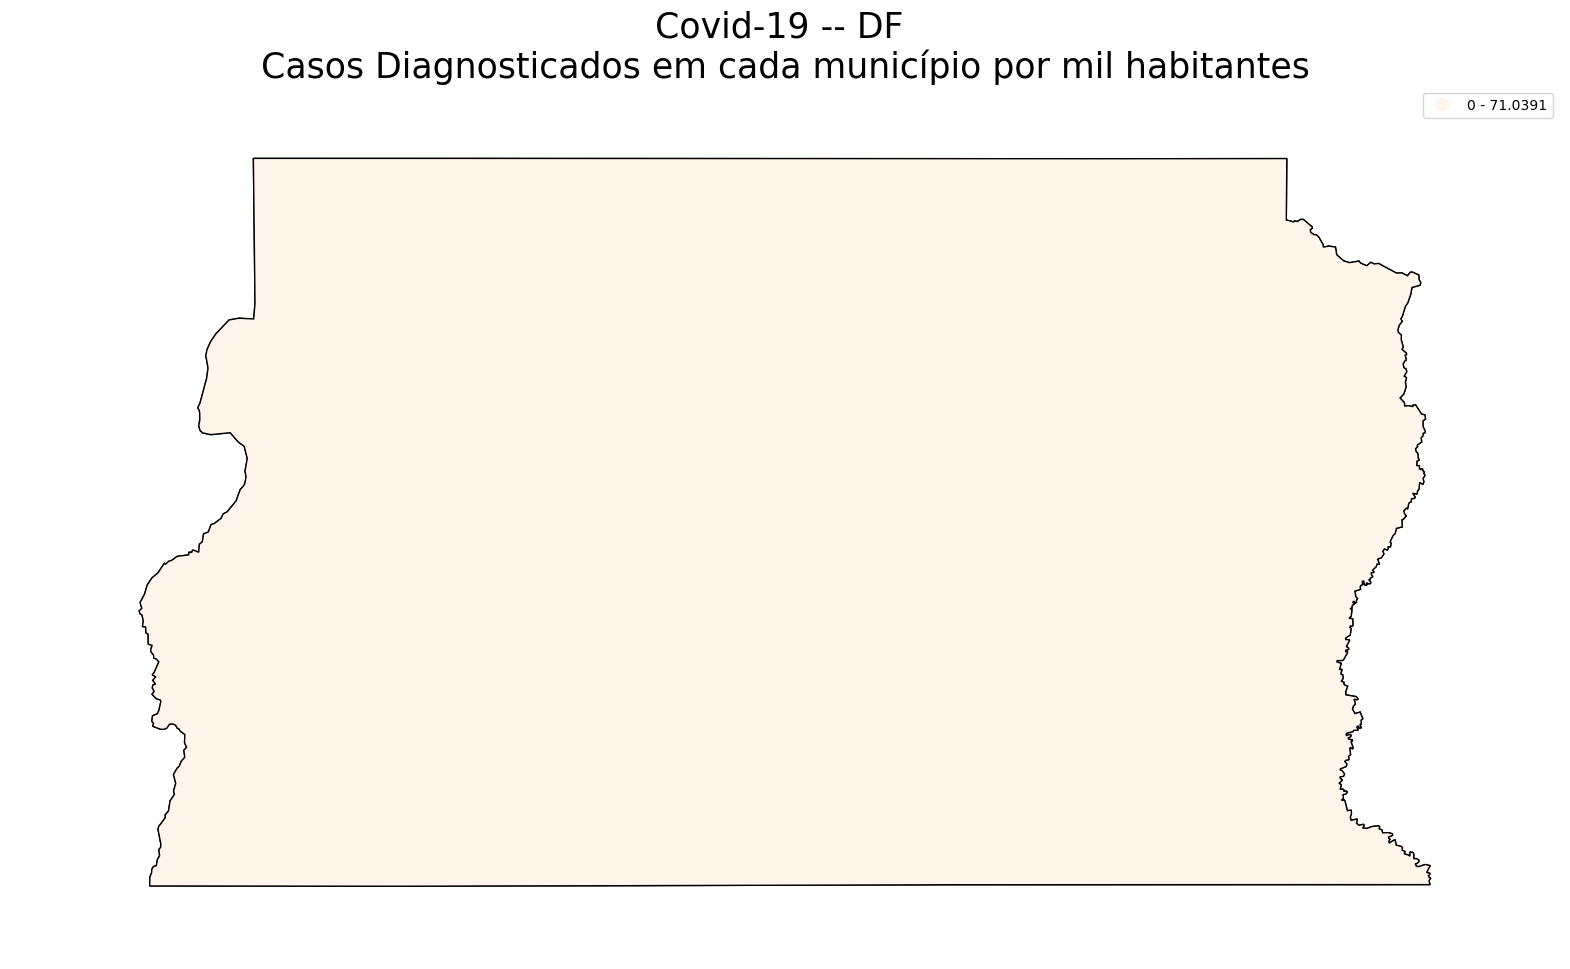

In [25]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

In [26]:
def mapa_obitos_estado(df, df_geo, uf, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid-19 -- {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


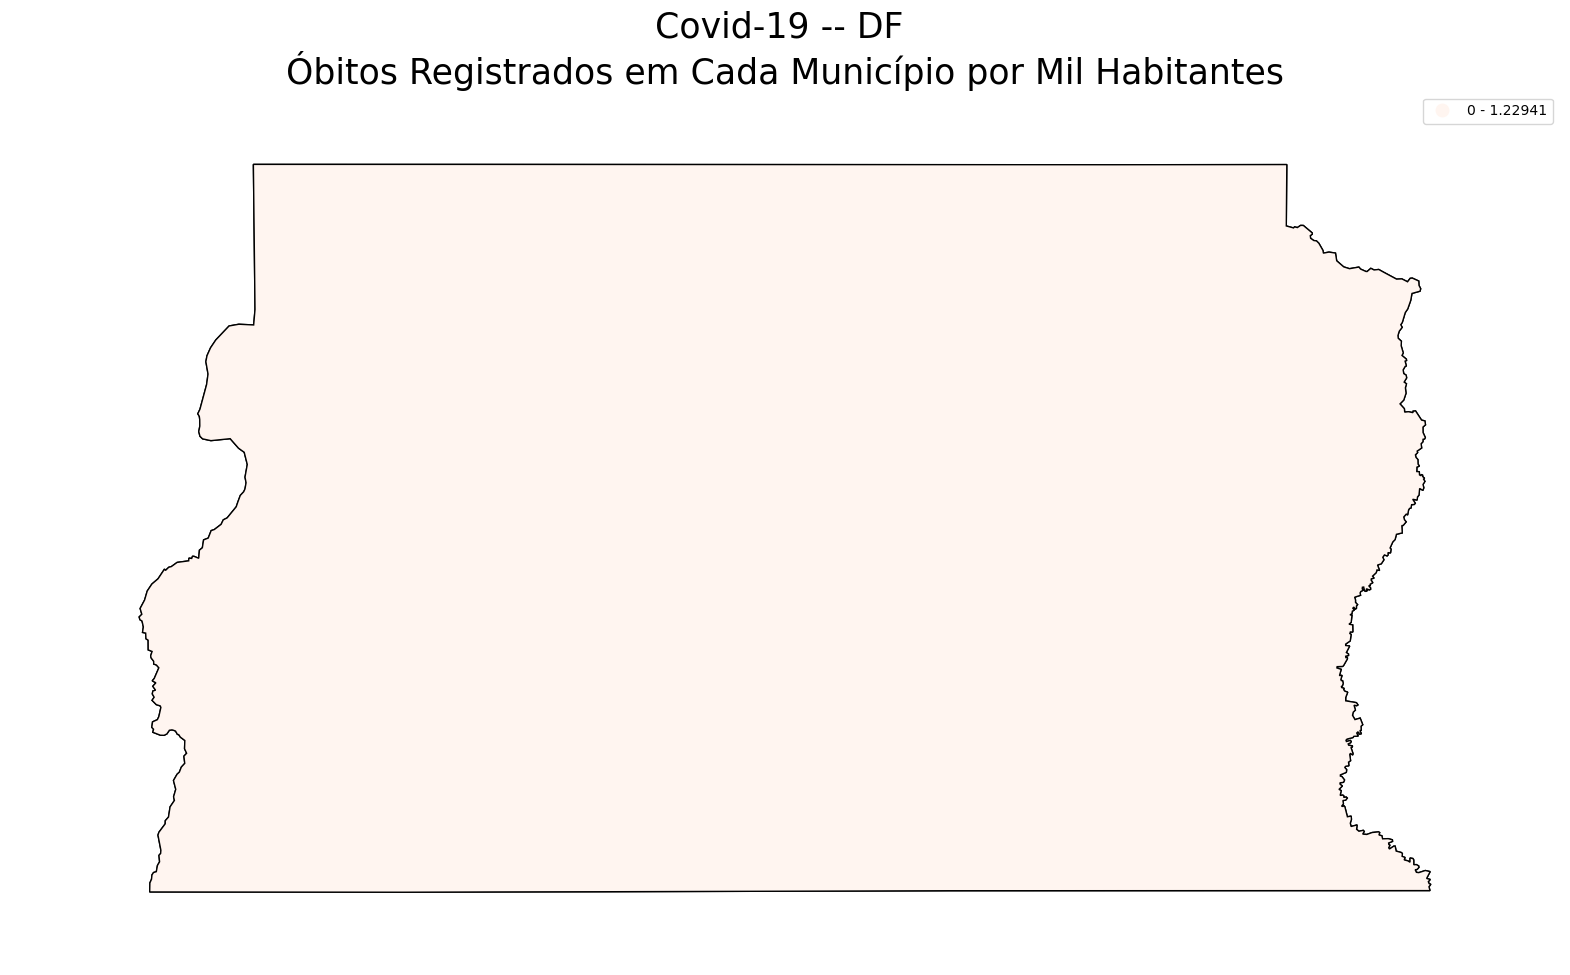

In [27]:
mapa_obitos_estado(df_est, mapa, uf, 20)